# Cross Validation
***

So far we have used `train_test_split` to validate our model.
However, it could be that we got bad luck when splitting our data.
For example, it could be that several extreme data points lie in the training or testing set or there are particular easy cases to predict which happen to be in the training or testing set.
To illustrate this and also introduce **feature engineering** let's load again the california housing dataset.

In [3]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

cali = fetch_california_housing(as_frame=True)
cali.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


We will again use linear regression to predict the median house value, but this time we will employ feature engineering to also take products of features into account.
This can be done by using the `PolynomialFeatures` function from `scikit-learn`.

### Feature engineering

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

The usage of `PolynomialFeatures` is the same as for `StandardScaler`.
In particular we could use it in a pipeline.
This time let's do it manually so that we actually know what is happening in the pipeline.

In [7]:
# instantiating the object
# look up the documentation of PolynomialFeatures to see all possible parameters
poly = PolynomialFeatures()

# to transform our data we first have to fit it
poly.fit(cali.data)

# then we transform it using the transform function
poly_cali = poly.transform(cali.data)

Let's have a look at the new features.

In [10]:
poly.get_feature_names_out()

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype=object)

As we can see, `PolynomialFeatures` multiplies each feature with all other features including itself.
There is a shorthand for tranforming data.

In [13]:
poly_cali = poly.fit_transform(cali.data)

Now let's train a model using these extended features.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(poly_cali, cali.target, random_state=42)

poly_lr = make_pipeline(StandardScaler(), LinearRegression())

poly_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

Now let's look at the scores.

In [18]:
print("Train score: {}".format(poly_lr.score(X_train, y_train)))
print("Test score: {}".format(poly_lr.score(X_test, y_test)))

Train score: 0.6829089327528396
Test score: 0.6563005880757413


Looks good! 
Remember last time, we were able to achieve a score of about 60 for training and testing.
Let's try again with a different random seed.
This time we make a pipeline for everything.

In [26]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(cali.data,
                                                               cali.target, 
                                                               random_state = 69)

poly_lr_v2 = make_pipeline(PolynomialFeatures(), StandardScaler(), LinearRegression())

poly_lr_v2.fit(X_train_v2, y_train_v2)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [27]:
print("Train score: {}".format(poly_lr_v2.score(X_train_v2, y_train_v2)))
print("Test score: {}".format(poly_lr_v2.score(X_test_v2, y_test_v2)))

Train score: 0.689648550496945
Test score: -0.005947614052453698


As you can see, the test score suddenly is very bad. 
It seems somehow that the random seed 42 is particularly favorable for polynomial features.
To get a more stable validation of our model, we will look at **cross validation**.

### Cross-Validation

Cross-validation allows estimating the robustness of the model by repeating the splitting procedure. 
It will give several training and testing errors, depending on the number of iterations, and thus some estimate of the variability of the generalizing performance.

There are different cross-validation strategies.
We will illustrate the *shuffle-split*.
At each iteration step, we perform the following actions:
* Randomly shuffle the dataset
* split the shuffled dataset into training and testing
* train a *new* model on the training set
* evaluate testing error on the testing set

Here is an illustration of the shuffle-split with 5 iterations.
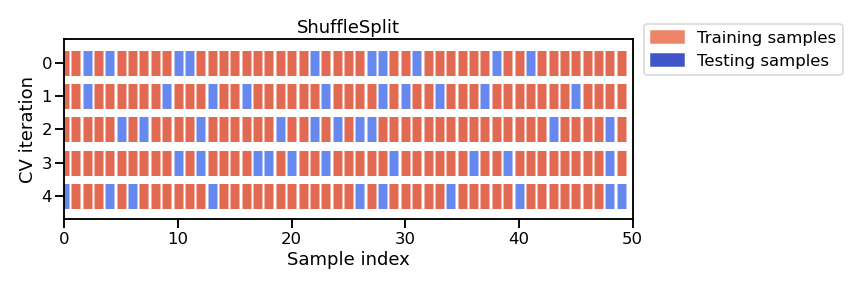

Let's apply this cross-validation technique to our example and look at the results.
We will use 40 iteration steps.

In [28]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(poly_lr_v2, cali.data, cali.target, cv=cv)

The results are stored in a python dictionary.
We convert it into a data frame for ease of use.

In [30]:
results = pd.DataFrame(cv_results)
results

,fit_time,score_time,test_score
0,0.038741,0.009495,-0.602854
1,0.043720,0.007727,-143.447444
2,0.049275,0.006568,-42.527035
3,0.055350,0.013019,-1.807898
4,0.045949,0.005408,0.197369
5,0.040568,0.005498,-104.996497
6,0.039838,0.005584,0.623708
7,0.037600,0.005157,-6.124259
8,0.038808,0.005064,-1.461666
9,0.039634,0.005307,-105.423014


Let's look at the distribution of the scores.

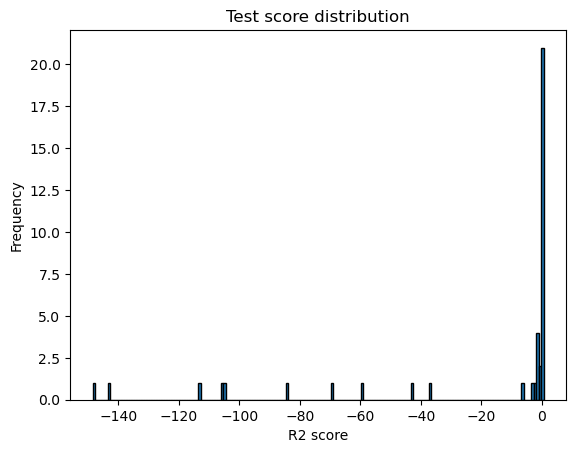

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

results["test_score"].plot.hist(bins=180, edgecolor="black")
plt.xlabel("R2 score")
_ = plt.title("Test score distribution")

In [42]:
print(results["test_score"].mean())
print(results["test_score"].std())

-22.901229347859505
43.93975503547355


Let's also cross validate linear regression without polynomial features.

In [44]:
lr = make_pipeline(StandardScaler(), LinearRegression())
no_poly_results = cross_validate(lr, cali.data, cali.target, cv=cv)

In [45]:
no_poly_results = pd.DataFrame(no_poly_results)
no_poly_results

,fit_time,score_time,test_score
0,0.011929,0.003110,0.592609
1,0.009971,0.002403,0.595461
2,0.010385,0.002526,0.593190
3,0.009627,0.002746,0.622851
4,0.009569,0.003205,0.611378
5,0.015408,0.002541,0.599018
6,0.012698,0.002477,0.598391
7,0.011444,0.003126,0.614486
8,0.011904,0.002417,0.605993
9,0.009989,0.002261,0.584273


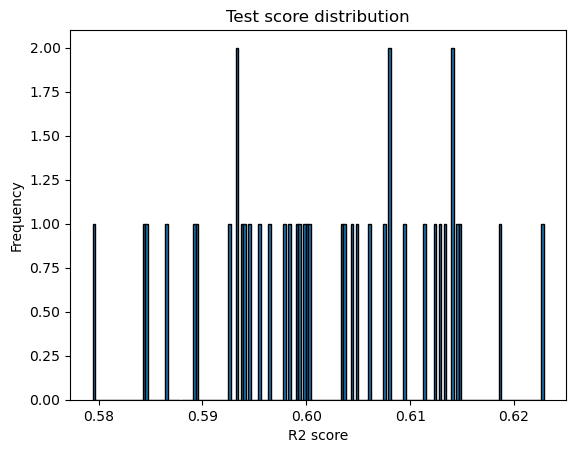

In [46]:
no_poly_results["test_score"].plot.hist(bins=180, edgecolor="black")
plt.xlabel("R2 score")
_ = plt.title("Test score distribution")

To get more information, we should also look at the target distribution.


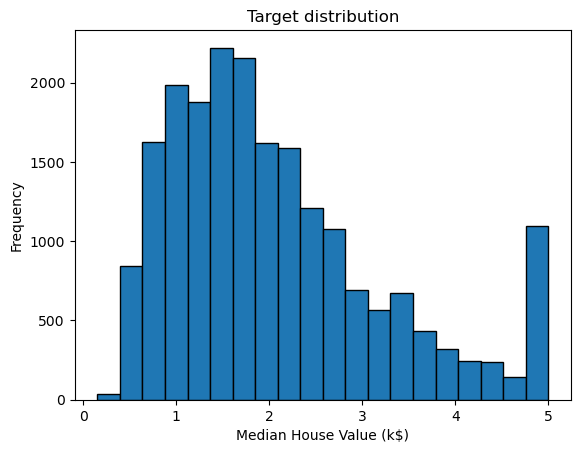

In [47]:
cali.target.plot.hist(bins=20, edgecolor="black")
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")

We see that there some extreme values (which are capped off), could this be the reason why having polynomial features performs worse?

# Exercise Class Competition

Create a good model for the California housing regression problem!


* You will be able to share your results on grips
* We will also modify the dataset and keep a test set separate and you can evaluate on the test set next week
* Whoever gets the best score will get a beverage of their choice and should present their solution in the exercise class
* You are free to use any resources and algorithms you like but you should be able to explain what you are doing

The best $R^2$ score I could find online was around .8.